In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from torchvision.transforms.functional import resize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(device))

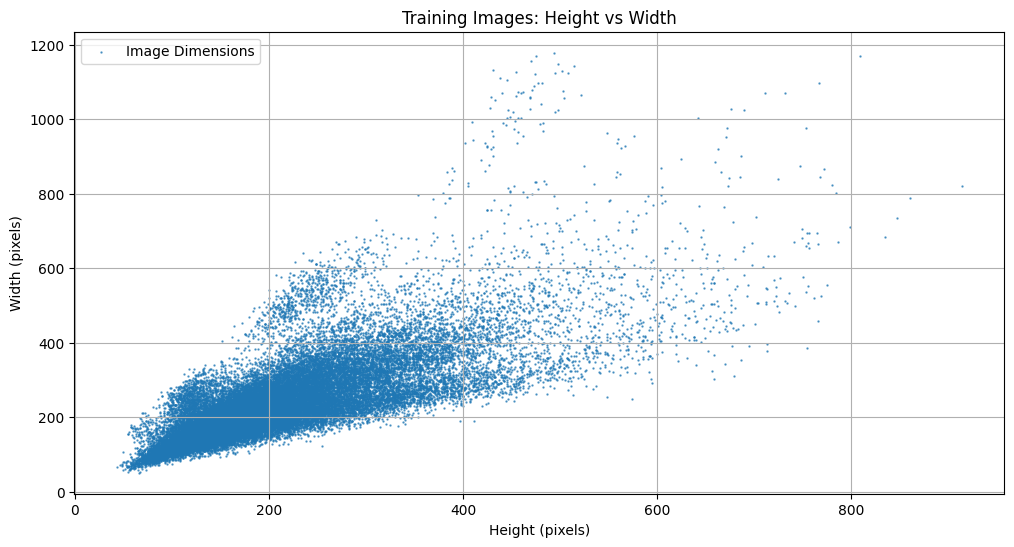

In [9]:
import os
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def collect_dimensions(image_dir):
    dimensions = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                dimensions.append(result)

    return dimensions

def plot_histogram(dimensions, title):
    heights = [dim[1] for dim in dimensions]
    widths = [dim[0] for dim in dimensions]

    plt.figure(figsize=(12, 6))
    plt.scatter(heights, widths, alpha=0.7, s=0.5, label="Image Dimensions")  # Adjusted s parameter for smaller dots
    plt.title(title)
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_dir = r"C:\Users\ahmad\Vision Project\env1\Custom-TrackNet-X\DataSet\VeRi\image_train"

train_dimensions = collect_dimensions(train_dir)

if train_dimensions:
    plot_histogram(train_dimensions, "Training Images: Height vs Width")
else:
    print("No dimensions collected for training images.")

In [10]:
width = 256
height = 196